/home/martina/.conda/envs/dae_cond/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model params: 15.37 M
[ 0 41 42 43 44 45 46 47 48 49 50]
{41: 0.11111, 42: 0.22222, 43: 0.33333, 44: 0.44444, 45: 0.55556, 46: 0.66667, 47: 0.77778, 48: 0.88889, 49: 1.0}
shape: torch.Size([1, 1, 144, 96])
[-0.22594312 -0.20938942 -0.20502232 ...  0.99998266  0.9999866
  1.        ]
[0.      0.11111 0.22222 1.     ]
Values in the range: tensor([1.7963, 1.2590, 1.9352, 1.4113, 1.0741, 1.4882, 1.3540, 1.9603, 1.1237,
        1.1749, 1.4844, 1.5257, 1.1275, 1.4809, 1.8989, 1.0488, 1.2581, 1.8266,
        1.0165, 1.4593, 1.8387, 1.4212, 2.0533, 1.9144, 1.9884, 1.2921, 1.2269,
        1.1373, 1.9409, 2.1264, 2.1017, 1.4036, 1.5868, 1.3499, 1.8956, 1.2398,
        1.0600, 1.4803, 2.2754, 1.0990, 1.5821, 1.1000, 1.4790, 1.7987, 1.2833,
        1.7833, 1.0013, 1.2481, 1.6069, 1.3666, 1.3285, 1.7291, 1.3071, 2.2494,
        1.6382, 1.2846, 1.0876, 1.5974, 1.8143, 1.9678, 1.3656, 1.6592, 1.5165,
        1.0538, 1.1100, 2.1104, 1.4000, 1.1525, 1.1063, 1.6021, 1.3572, 1.0895,
        1.6689, 1.611

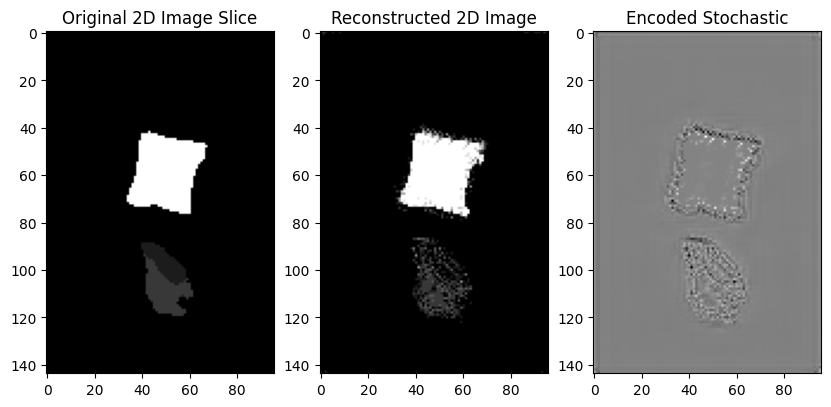

In [1]:
from pathlib import Path
from pl_models.DEA import DAE_LitModel
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torchvision import transforms
from BIDS import NII
from BIDS.core.np_utils import np_dice
import numpy as np
from BIDS.core.np_utils import np_map_labels, Label_Map
from sklearn.manifold import TSNE


def segmentation_map_to_model_map(y):
        y = y.astype(float)
        labelmap = {i: round((i - 40)/9, ndigits=5) for i in range(41, 50)} #  labelmap = {i: round((i - 40)/9, ndigits=2) for i in range(41, 50)}
        print(labelmap)
        return np_map_labels(y, labelmap)
def model_map_to_segmentation_map(x):
    x *= 9
    # Define the range
    lower_bound = 1.0
    upper_bound = 1.2

    # Find values and indices within the range
    condition = (x >= lower_bound) & (x <= upper_bound)
    values_in_range = x[condition]
    indices_in_range = torch.nonzero(condition)

    # Print the values and indices
    print("Values in the range:", values_in_range)
    print("Indices in the range:", indices_in_range)
   # x = x*0 if x < 0 else x*1
    x = np.round(x)# round nearest int
    x = x/9
    print("rounded*10",x)
   # x = x + 39
    #x = np_map_labels(x, {0.1: 0})
    return x
#"/media/DATA/martina_ma/cutout/verse040/verse040_023_subreg_cropped.nii.gz",#
#/media/DATA/martina_ma/cutout/tri177/tri177_007_subreg_cropped.nii.gz 
nii = NII.load(
    "/media/DATA/martina_ma/cutout/verse040/verse040_023_subreg_cropped.nii.gz",
    True,
)
seg_arr = nii.get_seg_array()

# Load the checkpoint and move the model to the specified device
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_136/checkpoints/epoch=28-step=2870_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_141/checkpoints/epoch=30-step=3075_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_142/checkpoints/epoch=3-step=310_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_148/checkpoints/epoch=7-step=780_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_149/checkpoints/epoch=3-step=340_latest.ckpt
#lightning_logs/DAE_NAKO_256/version_150/checkpoints/epoch=35-step=3600_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_27/checkpoints/last.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_150/checkpoints/epoch=35-step=3600_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_151/checkpoints/epoch=69-step=7140_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_183/checkpoints/epoch=102-step=9795_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_183/checkpoints/epoch=68-step=6610_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_183/checkpoints/epoch=68-step=6610_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_232/checkpoints/epoch=283-step=27190_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_249/checkpoints/epoch=147-step=71485_latest.ckpt
checkpoint_path ="/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_249/checkpoints/epoch=147-step=71485_latest.ckpt"# "/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_133/checkpoints/epoch=3-step=310_latest.ckpt"
#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_135/checkpoints/epoch=27-step=2775_latest.ckpt"#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_133/checkpoints/epoch=3-step=310_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_118/checkpoints/epoch=80-step=243_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_116/checkpoints/epoch=81-step=246_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_108/checkpoints/epoch=47-step=144_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_105/checkpoints/epoch=69-step=210_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_63/checkpoints/epoch=79-step=240_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_60/checkpoints/epoch=71-step=216_latest.ckpt"#lightning_logs/DAE_NAKO_256/version_26/checkpoints/epoch=404-step=405_latest.ckpt"
device = "cuda:0"  # or "cpu" if you want to use CPU
assert Path(checkpoint_path).exists()
model = DAE_LitModel.load_from_checkpoint(checkpoint_path)
model.ema_model.eval()
model.ema_model.to(device)

# Load the NIfTI image
#overfit_sample_path = "/media/DATA/martina_ma/datasets/verse013/verse011_008_subreg_cropped.nii.gz"#verse013_021_subreg_cropped.nii.gz"#"/media/DATA/martina_ma/datasets/verse013_023_subreg_cropped.nii.gz"
img_nifti = seg_arr#nib.load(overfit_sample_path)
print(np.unique(img_nifti))
print(img_nifti[144,96,144])
img_nifti = np_map_labels(arr=seg_arr,label_map={50: 49})
img_nifti = segmentation_map_to_model_map(img_nifti)

z_slice = img_nifti.shape[2] // 2  # Choose the middle slice or adjust as needed


img_slice = img_nifti[:, :,z_slice]#img_nifti.get_fdata()[:, :, z_slice]  # Extract the 2D slice
#img_slice = np.where(img_slice < 0.1111, 0.0, 1.0)
#img_slice = map_labels_(img_slice)
#img_slice = img_slice.astype(float)
#print(np.unique(img_slice))
#img_slice = map_labels_(img_slice)
#img_slice = img_slice/49
# Convert the 2D slice to a PyTorch tensor and preprocess it for the model (e.g., normalization), transforms.Normalize(mean, std)

transform = transforms.Compose([transforms.ToTensor()])
img_data = transform(img_slice).unsqueeze(0).to(device, dtype=torch.float32)
#print(img_data)
# Ensure that the input has a single channel (if the model expects 1 channel)
if img_data.shape[1] != 1:
    img_data = img_data.mean(1, keepdim=True)

# Encode the 2D image slice
cond = model.encode(img_data.to(device))

# # Convert embeddings to numpy array
# embeddings_np = cond.cpu().detach().numpy()

# # Apply t-SNE to reduce dimensionality to 2D
# tsne = TSNE(n_components=2,  perplexity=0.5,random_state=42)
# embeddings_tsne = tsne.fit_transform(embeddings_np)

# # Visualize the embeddings
# plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
# plt.title('t-SNE Visualization of Embeddings')
# plt.show()


# Decode the encoded representation to obtain the reconstructed 2D image
T = 20  # Adjust T as needed
stoch = model.encode_stochastic(img_data.to(device), cond, T=250)
xT = model.render(stoch, cond, T=T) #pred = model.render(xT, cond, T=20)
reconstructed_img = xT#[0]#(xT[0] + 1) / 2  # De-normalize if needed
print("shape:",reconstructed_img.shape)
# Move the reconstructed_img to CPU
# Set values smaller than 0.1111 to 0, and others to 1
reconstructed_img = reconstructed_img.cpu()
#reconstructed_img = torch.where(reconstructed_img < 0.11111, torch.tensor(0.0), torch.tensor(1.0))
print(np.unique(reconstructed_img))
#reconstructed_img = torch.clamp(reconstructed_img, min=0)
print(np.unique(img_slice))

reconstructed_img = torch.where(reconstructed_img < 0.1, torch.tensor(0.0), reconstructed_img)
reconstructed_img = model_map_to_segmentation_map(reconstructed_img)
print(np.unique(img_slice))
#
print(reconstructed_img[0].shape)
print(np.unique(reconstructed_img))


fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img_slice, cmap="gray")
ax[0].set_title("Original 2D Image Slice")
ax[1].imshow(reconstructed_img[0].permute(1, 2, 0), cmap="gray") #.permute(1, 2, 0)
ax[1].set_title("Reconstructed 2D Image")
ax[2].imshow(stoch[0].permute(1, 2, 0).cpu(), cmap="gray")
ax[2].set_title("Encoded Stochastic")
print(img_slice.shape)
#ax[3].imshow(cond[0].permute(1, 2, 0).cpu(), cmap="gray")
#np_dice()
plt.show()


In [2]:
img = np.squeeze(reconstructed_img, axis=0)
re = img.numpy()
re = re*9 + 40

re = np_map_labels(re, {40: 0})
print(np.unique(re))
nii.set_array(re).save("Reconstructed_verse011_008_subreg_cropped.nii.gz")
#img_slice = np.where(img_slice < 0.1111, 0.0, 1.0)

print(type(img_slice))
print(img_slice.shape)
r = reconstructed_img[0][0].numpy().copy()
#r[r<=0.8] = 0
print(np_dice(img_slice, r, binary_compare= True))
print(np.unique(img_slice))
print(np.unique(reconstructed_img[0][0].numpy()))

[ 0. 41. 42. 43. 44. 45. 46. 47. 48. 49.]
[*] Save Reconstructed_verse011_008_subreg_cropped.nii.gz as uint8
<class 'numpy.ndarray'>
(144, 96)
0.8441860465116279
[0.      0.11111 0.22222 1.     ]
[0.         0.11111111 0.22222222 0.33333334 0.44444445 0.5555556
 0.6666667  0.7777778  0.8888889  1.        ]


In [1]:
from pathlib import Path
from pl_models.DEA import DAE_LitModel
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torchvision import transforms
from BIDS import NII
from BIDS.core.np_utils import np_dice
import numpy as np
from BIDS.core.np_utils import np_map_labels, Label_Map
from sklearn.manifold import TSNE
from dataloader.datasets.dataset_csv import model_map_to_segmentation_map, segmentation_map_to_model_map 
#3D
def load_nifti(nii):
        
        from_im = nii.get_seg_array()
        #range_print(torch.from_numpy(from_im.astype(float)),41,41)
        #print(from_im[143,95,:])
        print(np.unique(from_im))
        from_im = np_map_labels(arr=from_im,label_map={50: 49})
        from_im = from_im.astype(float)
        from_im = segmentation_map_to_model_map(from_im)
        #from_im = (from_im-0.5)/0.5
        # print(from_im[143,95,143])
        # print("from_im shape:", from_im.shape)
        # print("mapped:",np.unique(from_im))
        from_im = torch.from_numpy(from_im).unsqueeze(0).unsqueeze(0)
        print("from_im shape:", from_im.shape)
        from_im = from_im.to(torch.float32)
        
        print("tesnor", from_im.shape)
        return from_im # , "index": target, "cls_labels": target}
# def map_to_binary(y):
#         #y = y.astype(float)
#         labelmap = {i: 1 for i in range(41, 50)} #  labelmap = {i: round((i - 40)/9, ndigits=2) for i in range(41, 50)}
#         #print(labelmap)
#         return np_map_labels(y, labelmap)
# def segmentation_map_to_model_map(y):
#         y = y.astype(float)
#         labelmap = {i: round((i - 40)/9, ndigits=5) for i in range(41, 50)} #  labelmap = {i: round((i - 40)/9, ndigits=2) for i in range(41, 50)}
#         print(labelmap)
#         return np_map_labels(y, labelmap)
# def model_map_to_segmentation_map(x):
#     x =(x+1)/2
#     x *= 9
#     x = np.round(x+40)# round nearest int
#    # x = x+40
#     x = np_map_labels(x, {40: 0})
#     return x

# def model_map_to_binary_map(x):
#     x = np.round(x)
#     return x

def range_print(x, lb, ub):
    # Define the range
    lower_bound = 0.1
    upper_bound = 0.12

    # Find values and indices within the range
    condition = (x >= lb) & (x <= ub)
    values_in_range = x[condition]
    indices_in_range = torch.nonzero(condition)

    # Print the values and indices
    print("Values in the range:", values_in_range)
    print("Indices in the range:", indices_in_range)
#"/media/DATA/martina_ma/cutout/verse040/verse040_023_subreg_cropped.nii.gz",#
#/media/DATA/martina_ma/cutout/tri177/tri177_007_subreg_cropped.nii.gz 
#in training set: /media/DATA/martina_ma/cutout/verse040/verse040_018_subreg_cropped.nii.gz
#not in train and not in val: /media/DATA/martina_ma/cutout/verse040/verse040_023_subreg_cropped.nii.gz
# Test sample /media/DATA/martina_ma/cutout/tri050/tri050_021_subreg_cropped.nii.gz
# Train sample in old seg /media/DATA/martina_ma/cutout/verse529/verse529_014_new_subreg_cropped.nii.gz
nii = NII.load(
    "/media/DATA/martina_ma/cutout/tri050/tri050_021_subreg_cropped.nii.gz",
    True,
)
from_im = load_nifti(nii)
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_276/checkpoints/epoch=10-step=4960_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_246/checkpoints/epoch=10-step=4940_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_241/checkpoints/epoch=9-step=4830_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_247/checkpoints/epoch=49-step=24300_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_249/checkpoints/epoch=147-step=71485_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D/version_27/checkpoints/epoch=6-step=1480_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D/version_37/checkpoints/epoch=4-step=1190_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_binary/version_6/checkpoints/epoch=10-step=2440_latest.ckpt -binary
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_binary/version_16/checkpoints/epoch=40-step=9905_latest.ckpt
#lightning_logs/DAE_NAKO_256/version_247
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_big_model/version_6/checkpoints/epoch=59-step=14425_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_big_model/version_40/checkpoints/epoch=237-step=57750_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_big_model/version_56/checkpoints/epoch=48-step=11860_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_big_model/version_60/checkpoints/epoch=49-step=12030_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_big_model/version_66/checkpoints/epoch=48-step=11905_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_big_model/version_84/checkpoints/epoch=49-step=12130_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_big_model/version_109/checkpoints/epoch=40-step=9960_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_95_old_verse_w_norm/version_3/checkpoints/epoch=15-step=23775_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_95_old_verse_w_norm/version_6/checkpoints/epoch=85-step=126920_latest copy.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_95_old_verse_w_norm/version_6/checkpoints/epoch=94-step=140260_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_95_old_verse_w_norm/version_11/checkpoints/epoch=0-step=1488_d_score_latest.ckpt
checkpoint_path ="/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_95_old_verse_w_norm/version_11/checkpoints/epoch=0-step=1488_d_score_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_232/checkpoints/epoch=283-step=27190_latest.ckpt"# "/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_133/checkpoints/epoch=3-step=310_latest.ckpt"
#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_135/checkpoints/epoch=27-step=2775_latest.ckpt"#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_133/checkpoints/epoch=3-step=310_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_118/checkpoints/epoch=80-step=243_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_116/checkpoints/epoch=81-step=246_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_108/checkpoints/epoch=47-step=144_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_105/checkpoints/epoch=69-step=210_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_63/checkpoints/epoch=79-step=240_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_60/checkpoints/epoch=71-step=216_latest.ckpt"#lightning_logs/DAE_NAKO_256/version_26/checkpoints/epoch=404-step=405_latest.ckpt"
device = "cuda:0"  # or "cpu" if you want to use CPU
assert Path(checkpoint_path).exists()
model = DAE_LitModel.load_from_checkpoint(checkpoint_path)
model.ema_model.eval()
model.ema_model.to(device)

img_data = from_im.to(device)
print(np.unique(img_data[0][0].cpu().numpy()))
range_print(img_data[0][0].cpu(),0.1,0.12)
print("torch:",img_data.shape)
# Ensure that the input has a single channel (if the model expects 1 channel)
if img_data.shape[0] != 1:
    raise Exception()
    #img_data = img_data.mean(1, keepdim=True)

print("mean:",img_data.shape)
# Encode the 2D image slice
# print("img_data_z:",img_data[0][0][143,95,:])
# print("img_data_y:",img_data[0][0][143,:,143])
# print("img_data_x:",img_data[0][0][:,95,143])

cond = model.encode(img_data)
print("cond")


# Decode the encoded representation to obtain the reconstructed 2D image
T = 200  # Adjust T as needed
stoch = model.encode_stochastic(img_data.to(device), cond, T=T)
xT = model.render(stoch, cond, T=T) #pred = model.render(xT, cond, T=20)
reconstructed_img = xT#[0]#(xT[0] + 1) / 2  # De-normalize if needed
print("shape:",reconstructed_img.shape)
# Move the reconstructed_img to CPU
# Set values smaller than 0.1111 to 0, and others to 1
reconstructed_img = reconstructed_img.cpu()
#reconstructed_img = torch.where(reconstructed_img < 0.11111, torch.tensor(0.0), torch.tensor(1.0))
print(np.unique(reconstructed_img))
print(reconstructed_img[0][0][143,95,143])
#reconstructed_img = torch.clamp(reconstructed_img, min=0)
#print(np.unique(img_slice))

#reconstructed_img = torch.where(reconstructed_img < 0, torch.tensor(0.0), reconstructed_img)
# print("re_z:",reconstructed_img[0][0][0,0,:])
# print("re_y:",reconstructed_img[0][0][0,:,0])
# print("re_x:",reconstructed_img[0][0][:,0,0])
r = reconstructed_img[0][0].numpy().copy()
reconstructed_img = model_map_to_segmentation_map(r)
# print(reconstructed_img[0][0][143,95,143])
# #print(np.unique(img_slice))
# #
# print(reconstructed_img[0].shape)
# print(np.unique(reconstructed_img))
# print("z:",reconstructed_img[0][0][0,0,:])
# print("y:",reconstructed_img[0][0][0,:,0])
# print("x:",reconstructed_img[0][0][:,0,0])




/home/martina/.conda/envs/dae_cond/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[ 0 41 42 43 44 45 46 47 48 49 50]
from_im shape: torch.Size([1, 1, 144, 96, 144])
tesnor torch.Size([1, 1, 144, 96, 144])
Model params: 1.27 M
[-1.      -0.77778 -0.55556 -0.33334 -0.11112  0.11112  0.33334  0.55556
  0.77778  1.     ]
Values in the range: tensor([0.1111, 0.1111, 0.1111,  ..., 0.1111, 0.1111, 0.1111])
Indices in the range: tensor([[ 85,  37,  54],
        [ 85,  37,  55],
        [ 85,  37,  56],
        ...,
        [103,  42,  56],
        [103,  42,  57],
        [103,  42,  58]])
torch: torch.Size([1, 1, 144, 96, 144])
mean: torch.Size([1, 1, 144, 96, 144])
cond
shape: torch.Size([1, 1, 144, 96, 144])
[-1.         -0.99999994 -0.9999999  ...  0.9999993   0.9999994
  1.        ]
tensor(-0.9998)


In [2]:
r = reconstructed_img.copy()
print("re_z:",r[0,0,:])
print("re_y:",r[0,:,0])
print("re_x:",r[:,0,0])
i = img_data[0][0].cpu().numpy().copy()
i = model_map_to_segmentation_map(i)
print(r.shape)
#r = r*9
#r = np.round(r)
re = r#+ 40
#print(np.unique(re))
#re = np_map_labels(re, {40: 0})
print(np.unique(re))
nii.set_array_(re).save("Reconstructions/Reconstructed_tri050_021_subreg_cropped_DAE_3D_95_old_verse_w_norm_version_11_epoch=0-step=1488_d_score_latest_T200_stochT200_denormalized.nii.gz")
print(np.unique(nii.get_array()))

print(np_dice(i, re, binary_compare= True))
print(np.unique(i))
#print(np.unique(reconstructed_img[0][0].numpy()))
print(np.unique(re))

re_z: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
re_y: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
re_x: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

: 

Dice Score: 0.8163191748918709 Reconstructed_verse040_018_subreg_cropped_DAE_3D_big_model_version_40_T200_stochT200.nii.gz as uint8
            0.8184233835252436 Reconstructed_verse040_018_subreg_cropped_DAE_3D_big_model_version_40_T500_stochT200.nii.gz
            0.9356895069232366 Reconstructed_verse040_018_subreg_cropped_DAE_3D_big_model_version_6_epoch=59-step=14425_latest_T200_stochT200.nii.gz
            
            0.747032221594121 [*] Save Reconstructions/Reconstructed_verse040_018_subreg_cropped_DAE_3D_big_model_version_56_epoch=48-step=11860_latest_T200_stochT200.nii.gz as uint8
            0.7508956971065732 [*] Save Reconstructions/Reconstructed_verse040_018_subreg_cropped_DAE_3D_big_model_version_56_epoch=48-step=11860_latest_T500_stochT500.nii.gz as uint8
             0.9821836026630826 Reconstructed_verse040_018_subreg_cropped_DAE_3D_big_model_version_version_60_epoch=49-step=12030_latest_T200_stochT200.nii.g
             0.9845967328286989 Reconstructed_verse040_018_subreg_cropped_DAE_3D_big_model_version_version_60_epoch=49-step=12030_latest_T125_stochT125.nii.gz

             0.9197384770131944 Reconstructed_verse040_018_subreg_cropped_DAE_3D_big_model_version_version_84_epoch=49-step=12130_latest_T250_stochT250.nii.gz
             0.9604307692307692 Reconstructed_verse040_018_subreg_cropped_DAE_3D_big_model_version_version_84_epoch=49-step=12130_latest_T500_stochT500.nii.gz
            0.965564142194745 Reconstructed_verse040_018_subreg_cropped_DAE_3D_big_model_version_version_84_epoch=49-step=12130_latest_T1000_stochT1000.nii.gz




In [3]:
x = [0,41,42,43,44,45,46,47,48,49]
for z in x:
    print((z-40)/9)

-4.444444444444445
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888
1.0


In [3]:
from pathlib import Path
from pl_models.DEA import DAE_LitModel
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torchvision import transforms
from BIDS import NII
from BIDS.core.np_utils import np_dice
import numpy as np
from BIDS.core.np_utils import np_map_labels, Label_Map
from sklearn.manifold import TSNE

#3D
def load_nifti(nii):
        
        from_im = nii.get_seg_array()
        range_print(torch.from_numpy(from_im.astype(float)),41,41)
        print(from_im[143,95,:])
        from_im = np_map_labels(arr=from_im,label_map={50: 49})
        from_im = from_im.astype(float)
        from_im = map_to_binary(from_im)
        print(from_im[143,95,143])
        print("from_im shape:", from_im.shape)
        print("mapped:",np.unique(from_im))
        from_im = torch.from_numpy(from_im).unsqueeze(0).unsqueeze(0)
        print("from_im shape:", from_im.shape)
        from_im = from_im.to(torch.float32)
        
        print("tesnor", from_im.shape)
        return from_im # , "index": target, "cls_labels": target}
def map_to_binary(y):
        #y = y.astype(float)
        labelmap = {i: 1 for i in range(41, 50)} #  labelmap = {i: round((i - 40)/9, ndigits=2) for i in range(41, 50)}
        #print(labelmap)
        return np_map_labels(y, labelmap)
def segmentation_map_to_model_map(y):
        y = y.astype(float)
        labelmap = {i: round((i - 40)/9, ndigits=5) for i in range(41, 50)} #  labelmap = {i: round((i - 40)/9, ndigits=2) for i in range(41, 50)}
        print(labelmap)
        return np_map_labels(y, labelmap)
def model_map_to_segmentation_map(x):
    #x *= 9
    #range_print(x,1,1.2)
    
    x = np.round(x)# round nearest int
    #x = x+40
    #print("rounded*10",x)
   # x = x + 39
    #x = np_map_labels(x, {40: 0})
    return x

def range_print(x, lb, ub):
    # Define the range
    lower_bound = 0.1
    upper_bound = 0.12

    # Find values and indices within the range
    condition = (x >= lb) & (x <= ub)
    values_in_range = x[condition]
    indices_in_range = torch.nonzero(condition)

    # Print the values and indices
    print("Values in the range:", values_in_range)
    print("Indices in the range:", indices_in_range)
#"/media/DATA/martina_ma/cutout/verse040/verse040_023_subreg_cropped.nii.gz",#
#/media/DATA/martina_ma/cutout/tri177/tri177_007_subreg_cropped.nii.gz 
#in training set: /media/DATA/martina_ma/cutout/verse040/verse040_018_subreg_cropped.nii.gz
#not in train and not in val: /media/DATA/martina_ma/cutout/verse040/verse040_023_subreg_cropped.nii.gz
nii = NII.load(
    "/media/DATA/martina_ma/cutout/verse040/verse040_018_subreg_cropped.nii.gz",
    True,
)
#from_im = load_nifti(nii)
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_276/checkpoints/epoch=10-step=4960_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_246/checkpoints/epoch=10-step=4940_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_241/checkpoints/epoch=9-step=4830_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_247/checkpoints/epoch=49-step=24300_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_249/checkpoints/epoch=147-step=71485_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D/version_27/checkpoints/epoch=6-step=1480_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D/version_37/checkpoints/epoch=4-step=1190_latest.ckpt
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_binary/version_6/checkpoints/epoch=10-step=2440_latest.ckpt -binary
#/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_binary/version_16/checkpoints/epoch=40-step=9905_latest.ckpt
checkpoint_path ="/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_binary/version_6/checkpoints/epoch=10-step=2440_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_232/checkpoints/epoch=283-step=27190_latest.ckpt"# "/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_133/checkpoints/epoch=3-step=310_latest.ckpt"
#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_135/checkpoints/epoch=27-step=2775_latest.ckpt"#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_133/checkpoints/epoch=3-step=310_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_118/checkpoints/epoch=80-step=243_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_116/checkpoints/epoch=81-step=246_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_108/checkpoints/epoch=47-step=144_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_105/checkpoints/epoch=69-step=210_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_63/checkpoints/epoch=79-step=240_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_60/checkpoints/epoch=71-step=216_latest.ckpt"#lightning_logs/DAE_NAKO_256/version_26/checkpoints/epoch=404-step=405_latest.ckpt"
device = "cuda:0"  # or "cpu" if you want to use CPU
assert Path(checkpoint_path).exists()
model = DAE_LitModel.load_from_checkpoint(checkpoint_path)
#model.ema_model.eval()
model.to(device)
#
img_data = model.sample(8,device)
print("torch:",img_data.shape)



Model params: 1.27 M


[[ 9.7138323e-03  3.2023195e-02  2.5478905e-02 ...  2.7285542e-02
   3.3293359e-02  3.9880730e-02]
 [-8.8444464e-03 -9.3581708e-04 -1.0632949e-03 ...  1.6723085e-03
  -2.2392260e-04  1.5973389e-02]
 [ 2.8241924e-03  4.4431873e-03  4.8482516e-03 ...  1.0599796e-02
   3.4246775e-03  2.2142209e-02]
 ...
 [ 9.2146263e-05  1.1151505e-03  1.3472330e-03 ...  6.4185103e-03
   3.4140949e-03  2.2136483e-02]
 [ 9.5998934e-03  3.9938777e-03  4.3294299e-03 ...  6.8743867e-03
   3.9976151e-03  1.8700227e-02]
 [ 5.5930880e-03  3.9706412e-03  4.0490781e-03 ...  9.0445932e-03
   5.7395436e-03  3.8843253e-03]]
0.8295418
0.8294229
0.8298783
0.8295549
0.8282882
0.82855517
0.82918227
0.82940257
0.8287503
0.82814133
0.82803476
0.8286182
0.8291456
0.8279234
0.8278575
0.8280117
0.8289639
0.82882786
0.82807964
0.82824135
0.82837147
0.82987946
1.0
[ 0 41 42 49]
[ 0 41 42 43 44 48 49]


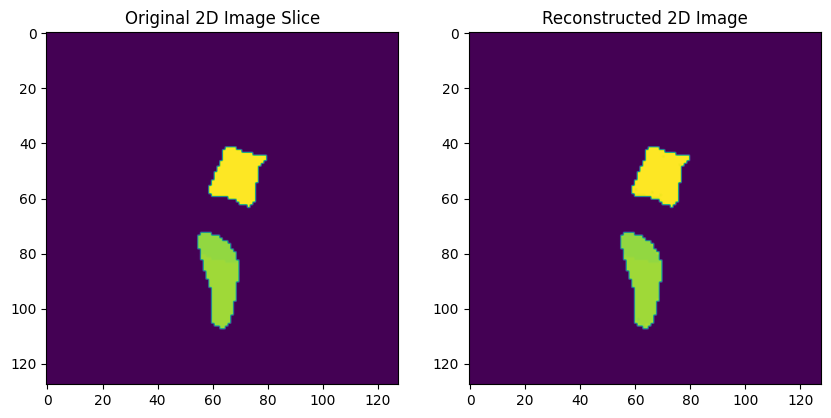

In [4]:
def map_labels(value):
    #[0.   0.82,41 0.84,42 0.86,43 0.88,44 0.9,45  0.92,46 0.94,47 0.96,48 0.98,49 1.,50  ]
    # todo auf 49 umskalieren
    if value <= 0.2:
        return 0
    if 0.827 <= value < 0.847:
        return 41 #0.8367
    if 0.847 <= value < 0.867:
        return 42 #0.8571
    if 0.867 <= value < 0.888:
        return 43 #0.8775
    if 0.888 <= value < 0.908:
        return 44 #0.8979
    if 0.908 <= value < 0.929:
        return 45 #0.9184
    if 0.929<= value < 0.949:
        return 46 #0.9388
    if 0.949 <= value < 0.969:
        return 47 #0.9592
    if 0.969 <= value < 0.990:
        return 48 #0.9796
    if 0.990 <= value <= 1.5:
        return 49
    #if 0.99 <= value <= 1.5:
     #   return 50
    return value

r = reconstructed_img[0][0].numpy().copy()
print(r)
for i in r.flatten():
    if 0.8 <= i < 0.83:
        print(i) # wieso wird hier label 41 so viel predicted obwohl es gar nicht auftaucht im orig img?
r = np.vectorize(lambda x: map_labels(x))(r)

img_slice = np.vectorize(lambda x: map_labels(x))(img_slice)

print(np_dice(img_slice, r, binary_compare= True))
print(np.unique(img_slice))
print(np.unique(r))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_slice)
ax[0].set_title("Original 2D Image Slice")
ax[1].imshow(r) #.permute(1, 2, 0)
ax[1].set_title("Reconstructed 2D Image")


plt.show()
#[0.03684453 0.03727458 0.03753474 ... 0.98750603 0.98803204 0.9885488 ]


In [2]:
import numpy as np
from BIDS.core.np_utils import np_map_labels
x = np.array([0, 41, 42, 43, 44, 45, 46, 47, 48, 49])
# segmentation map     print((z-40)/9)
def segmentation_map_to_model_map(y):
    y = y.astype(float)
    labelmap = {i: round(0.1*(i - 39), ndigits=2) for i in range(41, 50)} #  labelmap = {i: round((i - 40)/9, ndigits=2) for i in range(41, 50)}
    print(labelmap)
    return np_map_labels(y, labelmap)
def model_map_to_segmentation_map(x):
    x *= 10
    print("9:",x)
    x = np.round(x)# round nearest int
    print("rounded*10",x)
    x = x + 39
    x = np_map_labels(x, {39: 0})
    # map labels auf 41-49
    return x
a = segmentation_map_to_model_map(x)
print(a)
b = model_map_to_segmentation_map(a)
print(b)

{41: 0.2, 42: 0.3, 43: 0.4, 44: 0.5, 45: 0.6, 46: 0.7, 47: 0.8, 48: 0.9, 49: 1.0}
[0.  0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
9: [ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
rounded*9 [ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0. 41. 42. 43. 44. 45. 46. 47. 48. 49.]


In [1]:
from dataloader import dataset_factory
from utils import arguments
import matplotlib.pyplot as plt
import numpy as np
import torch

opt = arguments.DAE_Option()
ds = dataset_factory.get_dataset(opt, super_res=False)
#batch = data[0e]

/home/martina/.conda/envs/dae_cond/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/media/DATA/martina_ma/datasets/test_csv.csv


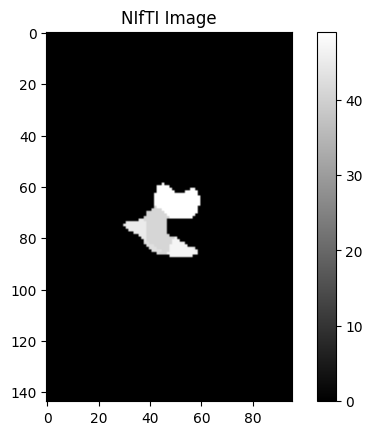

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
from BIDS.core.np_utils import np_dice
# Load the NIfTI image
overfit_sample_path = "/media/DATA/martina_ma/cutout/verse016/verse016_012_subreg_cropped.nii.gz"#"/media/DATA/martina_ma/datasets/verse011/verse011_008_subreg_cropped.nii.gz"#verse013_024_subreg_cropped.nii.gz"
img_nifti = nib.load(overfit_sample_path)

# Extract the image data as a NumPy array
img_data = img_nifti.get_fdata() #aufpassen wegen runderungen
img_slice = img_data[:, :, 60]
# Display the image using matplotlib
plt.imshow(img_slice, cmap="gray")  # Adjust the slice (60) as needed
plt.title("NIfTI Image")
plt.colorbar()
plt.show()


In [7]:
from coutouts import find_cutout, make_cutout
from BIDS import NII
from BIDS.core.np_utils import np_calc_crop_around_centerpoint, np_bbox_nd
from scipy import ndimage
import os

max_x = 0
max_y = 0
max_z = 0
max_cutout_size = (144, 96, 144)
subject = "verse406"
subreg_nii = NII.load(
    #"/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse214_seg-subreg_msk.nii.gz",
    "/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse261_seg-subreg_msk.nii.gz",
    True,
)
vert_nii = NII.load(
    #"/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse214_seg-vert_msk.nii.gz",
    "/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse261_seg-vert_msk.nii.gz",
    True,
)

vert_nii.rescale_()
vert_nii.reorient_()
subreg_nii.rescale_()
subreg_nii.reorient_()


labels = vert_nii.unique()
for label in labels:
    vert_label_nii = vert_nii.extract_label(label)
    vert_arr = vert_label_nii.get_seg_array()
    subreg_arr = subreg_nii.get_seg_array()#vert_arr_l1 = vert_L1.get_seg_array()
    subreg_arr_L1 = subreg_arr.copy()
    subreg_arr_L1[vert_arr == 0] = 0
    center_subreg = ndimage.center_of_mass(subreg_arr_L1)
    cropped_arr_subreg, cutout_coord_slices, padding = np_calc_crop_around_centerpoint(center_subreg, subreg_arr_L1, max_cutout_size)
#    nii_subreg_s = subreg_nii.set_array(cropped_arr_subreg)
    nii_subreg_s = subreg_nii.copy()
    nii_subreg_s.set_array_(cropped_arr_subreg)
    nii_subreg_s = nii_subreg_s.pad_to(max_cutout_size)
    nii_subreg_s.rescale_()
    nii_subreg_s.reorient_()
    #vert_label_nii.save("{}_{:03d}_vert_cropped.nii.gz".format(subject, label))
    folder = "/media/DATA/martina_ma/cutout/{}/".format(subject)
    if not os.path.exists(folder):
            os.makedirs(folder)
    nii_subreg_s.save("/media/DATA/martina_ma/cutout/{}/{}_{:03d}_subreg_cropped.nii.gz".format(subject,subject, label))


[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_007_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_008_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_009_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_010_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_011_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_012_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_013_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_014_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_015_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_016_subreg_cropped.nii.gz as uint8
[*] Save /media/DATA/martina_ma/cutout/verse406/verse406_017_subreg_cropped.nii.

In [6]:
from coutouts import find_cutout, make_cutout
from BIDS import NII
from BIDS.core.np_utils import np_calc_crop_around_centerpoint, np_bbox_nd
from scipy import ndimage
import os

subreg_nii = NII.load(
    #"/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse214_seg-subreg_msk.nii.gz",
    "/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse626/sub-verse626_dir-iso_seg-subreg_msk.nii.gz",
    True,
)
vert_nii = NII.load(
    #"/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse406/sub-verse406_split-verse214_seg-vert_msk.nii.gz",
    "/media/DATA/martina_ma/data/dataset-verse/derivatives_spine_r/sub-verse626/sub-verse626_dir-iso_seg-vert_msk.nii.gz",
    True,
)

vert_nii.reorient_()
subreg_nii.reorient_()
vert_nii.rescale_()
subreg_nii.rescale_()


labels = vert_nii.unique()
for label in labels:
    cut_size = find_cutout(vert_nii, label, None)
    

(61, 28, 71) 7
(65, 34, 76) 8
(67, 36, 69) 9
(70, 34, 66) 10
(73, 32, 65) 11
(70, 38, 66) 12
(70, 51, 63) 13
(70, 54, 63) 14
(70, 53, 60) 15
(68, 52, 60) 16
(72, 48, 57) 17
(74, 46, 45) 18
(6, 12, 12) 19
(77, 51, 68) 20
(84, 57, 69) 21
(83, 57, 79) 22
(84, 49, 85) 23
(82, 45, 89) 24
(65, 62, 122) 25


In [9]:
from pathlib import Path
from pl_models.DEA import DAE_LitModel
import nibabel as nib
first = ds[0]
print(type(first))
print(first)
print(ds)
batch = ds[0]['img'][None]
print(type(batch))
print(batch)

# def show(*img):
#     img = [i if len(i.shape) == 3 else i.squeeze(0) for i in img]
#     img = [(i.detach().cpu() if isinstance(i, torch.Tensor) else torch.from_numpy(i)) for i in img]
#     np_img = torch.cat(img, dim=-1).numpy()
#     plt.figure(figsize=(20, 6))
#     plt.imshow(np.transpose(np_img, (1, 2, 0)), interpolation="nearest", cmap="gray")

#show(*ds.get_img(9, 1).values())
""
#lightning_logs/DAE_NAKO_256/version_26/checkpoints/epoch=404-step=405_latest.ckpt
checkpoint_path = "/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_26/checkpoints/epoch=404-step=405_latest.ckpt"#"/media/data/robert/code/DiffAE/lightning_logs/DAE_NAKO_256/version_1/checkpoints/last.ckpt"
device: str | None = "cuda:0"
print("checkpoint_path", checkpoint_path)
assert Path(checkpoint_path).exists()
model = DAE_LitModel.load_from_checkpoint(checkpoint_path)
model.ema_model.eval()
model.ema_model.to(device)

    #### Load overfit sample ####
overfit_sample_path = "/media/DATA/martina_ma/datasets/verse013_023_subreg_cropped.nii.gz"
img_nifti = nib.load(overfit_sample_path)

import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())
print("decode")
pred = model.render(xT, cond, T=20)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

NameError: name 'ds' is not defined

In [11]:
from pathlib import Path
from pl_models.DEA import DAE_LitModel
c = "/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_19/checkpoints/last.ckpt"
print(Path(c).exists())
model: DAE_LitModel = DAE_LitModel.load_from_checkpoint(c)
#"lightning_logs/SuperDAE_DAE_NAKO_256/version_1/checkpoints/last.ckpt")
#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_37/checkpoints/last.ckpt
#/media/DATA/martina_ma/dae
#lightning_logs/DAE_NAKO_256/version_36
#lightning_logs/DAE_NAKO_256/version_36/checkpoints/last.ckpt

True
Model params: 16.19 M


In [14]:
device = torch.device("cuda:0")
#data = ds.get_img(8, 0)
# img_lr: torch.Tensor = data["img_lr"]
# img_lr.unsqueeze_(0)
# img_lr = img_lr.to(device)
# img_hr = data["img"]
# img_hr.unsqueeze_(0)

img_lr = batch[0]#.permute([1, 2, 0])
img_lr.unsqueeze_(0)
img_lr = img_lr.to(device)
cond = model.encode(img_lr)

xT = model.encode_stochastic(img_lr, cond, T=250)
pred = model.render(xT, cond, T=20)
pred2 = model.render(torch.randn_like(img_lr), cond, T=20)
pred3 = model.render(xT * 0.2, cond, T=20)


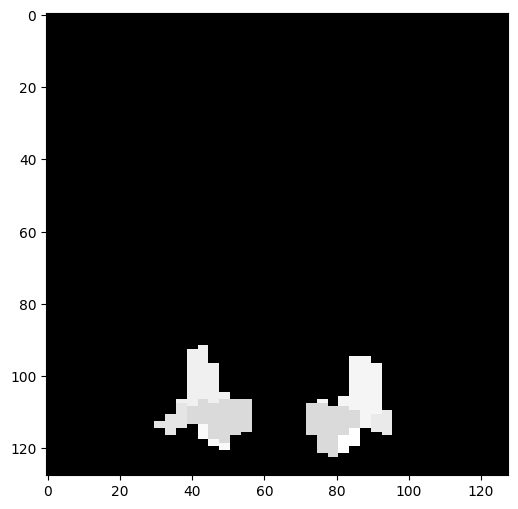

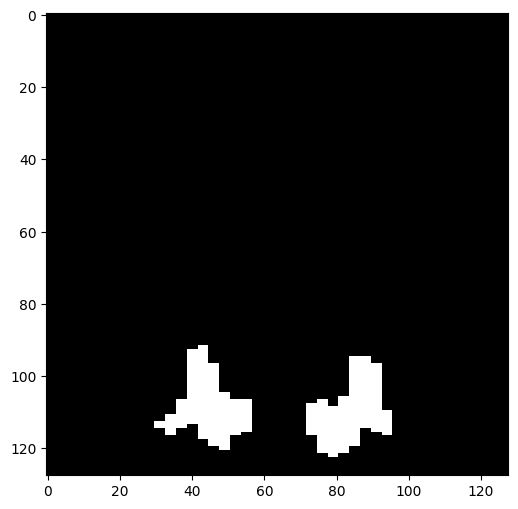

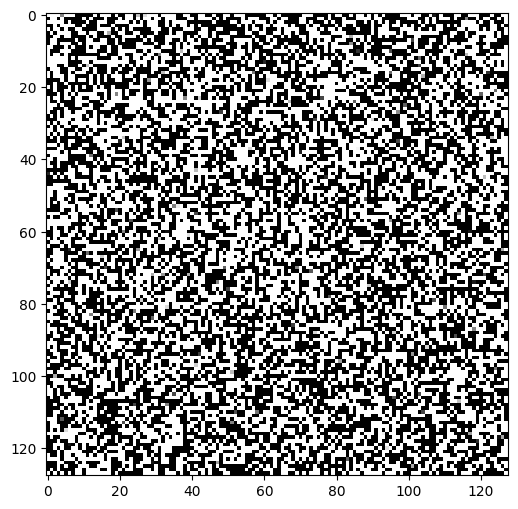

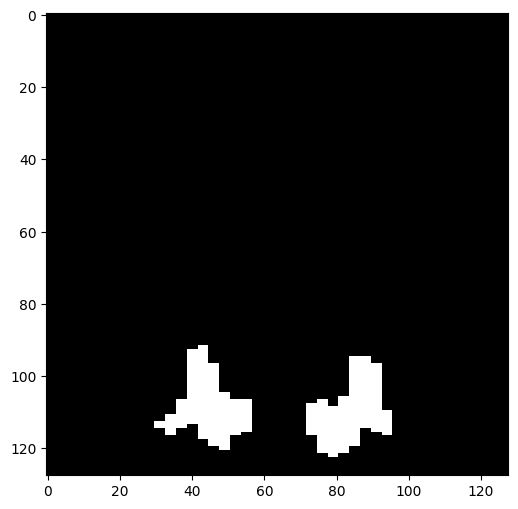

In [18]:
show(img_lr)
show(pred)
show(pred2)
show(pred3)

In [19]:
print(xT.min(), xT.max())
n = torch.randn_like(img_lr)
print(n.min(), n.max())

tensor(-0.0050, device='cuda:0') tensor(9399.8770, device='cuda:0')
tensor(-3.9598, device='cuda:0') tensor(3.8167, device='cuda:0')


In [20]:
from BIDS import NII
nifti = "/media/DATA/martina_ma/datasets/verse013_023_subreg_cropped.nii.gz" #"/media/data/robert/datasets/dataset-neuroboly/rawdata/sub-m034619/ses-20140114/anat/sub-m034619_ses-20140114_acq-ax_chunk-2_T2w.nii.gz"
nii = NII.load(nifti,
    False,
)
nii.reorient_().rescale_((0.8571, 0.8571, 0.8571))

# show(arr)

ModuleNotFoundError: No module named 'BIDS.core'

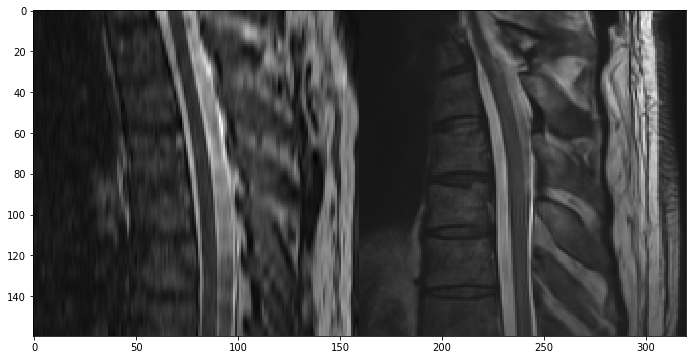

In [141]:
arr_new = nii.get_array()[:, :, nii.shape[-1] // 2]
from dataloader.datasets.dataset_superres import get_pads, target_pad

arr, _ = target_pad(arr_new, [160, 160])
a = 50
arr = arr[a : 160 + a, :160]


img_lr = torch.from_numpy(arr.T).unsqueeze_(0).unsqueeze_(0).to(device, torch.float32)
img_lr /= img_lr.max()
img_lr = img_lr * 2 - 1
cond = model.encode(img_lr)
pred2 = model.render(torch.randn_like(img_lr), cond, T=20)
show(img_lr.cpu().numpy(), pred2.cpu().numpy())

In [112]:
print(nii.shape)
print(nii.orientation)

(275, 188, 275)
('P', 'I', 'R')


In [163]:
a = 90

show(img_lr[..., :160, a : 160 + a])

ValueError: axes don't match array

<Figure size 1440x432 with 0 Axes>

In [1]:
labels = [0,40,41,42,43,44,45,46,47,48,49]
labels=labels[1:]
print(labels)

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [11]:
from monai.networks.nets import resnet18
import torch
resnet = resnet18(spatial_dims=3,n_input_channels=1)
pretrained_path = "/media/DATA/martina_ma/MedicalNet/pretrain/resnet_18_23dataset.pth" #TODO: check if datset or without
net_dict = resnet.state_dict()
pretrain = torch.load(pretrained_path)
pretrain['state_dict'] = {k.replace('module.', ''): v for k, v in pretrain['state_dict'].items()}
missing = tuple({k for k in net_dict.keys() if k not in pretrain['state_dict']})
print(f"missing in pretrained: {len(missing)}")
inside = tuple({k for k in pretrain['state_dict'] if k in net_dict.keys()})
print(f"inside pretrained: {len(inside)}")
unused = tuple({k for k in pretrain['state_dict'] if k not in net_dict.keys()})
print(f"unused pretrained: {len(unused)}")
assert len(inside) > len(missing)
assert len(inside) > len(unused)

pretrain['state_dict'] = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
resnet.load_state_dict(pretrain['state_dict'], strict=False)
#print(resnet)
#print(resnet.layer1[1])
#print(resnet.get_parameter)
for layer in resnet.children():
    print(layer.state_dict())

missing in pretrained: 23
inside pretrained: 102
unused pretrained: 0
OrderedDict([('weight', tensor([[[[[-5.9948e-02, -2.9903e-02, -3.5586e-02,  ..., -5.1637e-02,
            -4.7871e-02, -5.2698e-02],
           [-3.5046e-02, -3.5124e-02, -5.4881e-02,  ..., -4.3105e-02,
            -6.2667e-02, -5.3991e-02],
           [-8.6502e-03, -1.2492e-02, -3.3444e-02,  ..., -3.0728e-02,
            -5.6240e-02, -5.4166e-02],
           ...,
           [-3.8264e-03, -1.0459e-02, -1.6019e-02,  ..., -6.2960e-03,
            -4.1419e-03, -1.7896e-02],
           [ 1.9691e-02,  1.8119e-02,  3.1506e-02,  ..., -4.7270e-03,
             1.1292e-02, -5.2301e-03],
           [ 2.8091e-02,  4.5398e-03,  8.7798e-03,  ..., -6.8965e-05,
             2.1039e-02, -2.4368e-03]],

          [[-3.4954e-02, -2.9469e-02, -2.4564e-02,  ..., -6.0300e-02,
            -4.6508e-02, -5.3932e-02],
           [-4.5680e-02, -2.8258e-02, -3.7784e-02,  ..., -4.2587e-02,
            -2.2830e-02, -3.2380e-02],
           [-3.2